# Demo of SCOD on MNIST

In [2]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import torch.nn as nn
import matplotlib
import numpy as np
from tqdm import trange

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, KMNIST
from torch.utils.data import Subset
from matplotlib import pyplot as plt

In [3]:
mnist = MNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
dataset = Subset(mnist, np.random.choice(len(mnist), 5000))

In [4]:
# DNN mapping 2d input to 1d distribution parameter
# LeNet v5
model = nn.Sequential(
        nn.Conv2d(1, 6, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Conv2d(6, 16, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Flatten(),
        nn.Linear(256, 120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Categorical(logits=theta)

prior_weight_var = 2e3

100%|██████████| 25/25 [00:15<00:00,  1.61it/s, lr=0.00854, mean_loss=0.0779, mean_metric=0.00156]


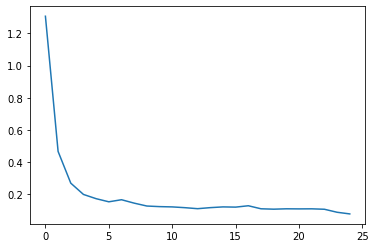

In [5]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

losses = []
n_epochs = 25
t = trange(n_epochs)

for epoch in t:
    epoch_loss = 0.
    epoch_metric = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)
        metric = dist.metric(targets)

        mean_loss = loss.mean()
        mean_metric = metric.mean()

        regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in model.parameters()])) / prior_weight_var

        total_loss = mean_loss + regularization

        total_loss.backward()

        epoch_loss += total_loss
        epoch_metric += mean_metric
        
        optimizer.step()
    scheduler.step()
        
    epoch_loss /= len(train_dataloader)
    epoch_metric /= len(train_dataloader)
    
    t.set_postfix(mean_loss=epoch_loss.item(), mean_metric=epoch_metric.item(), lr=scheduler.get_last_lr()[0] )
    losses.append(epoch_loss.item())

plt.plot(losses)

In [51]:
unc_model = scod.SCOD(model.to(torch.device("cuda:0")), dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'offline_proj_dim': 5,
})

In [52]:
unc_model.process_dataset(dataset)

computing basis
using T = 304


In [21]:
val_dataset =  MNIST(root="~/data/",train=False,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
val_ood_dataset = FashionMNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
kmnist_dataset = KMNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))

In [57]:
val_subset = Subset(val_dataset, np.random.choice(len(val_dataset), 5000))
ood_subset = Subset(val_ood_dataset, np.random.choice(len(val_ood_dataset), 5000))
val_plus_val_ood = torch.utils.data.ConcatDataset([val_dataset, val_ood_dataset])
val_plus_val_ood_subset = Subset(val_plus_val_ood, np.random.choice(len(val_plus_val_ood), 5000))

In [33]:
unc_model.optimize_nll(val_subset)

100%|██████████| 1/1 [00:03<00:00,  3.90s/it, eps=0.0208]


In [46]:
unc_model.optimize_nll(val_plus_val_ood_subset)

100%|██████████| 1/1 [00:37<00:00, 37.31s/it, eps=0.255]


In [58]:
unc_model.optimize_entropy_separation(val_subset, ood_subset)

In [9]:
unc_model.eps = prior_weight_var / unc_model.n_params

AttributeError: can't set attribute

In [10]:
unc_model.calibrate(Subset(val_dataset, np.random.choice(len(val_dataset), 500)),0.9)

100%|██████████| 50/50 [00:03<00:00, 16.23it/s]


In [24]:
## DEFINE VISUALIZATION FUNCTIONS
def plt_image(ax, inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = 0.1307
    std = 0.3081
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp[:,:,0], cmap='Greys')

def viz_dataset_sample(ax, dataset, idx=0, model=None, unc_model=None):
    input, target = dataset[idx]
    plt_image(ax, input)
    xlabel = 'Target: %d' % target
    if unc_model is not None:
        pred, unc = unc_model(input.unsqueeze(0).to(unc_model.device))
        pred = np.argmax(pred[0].probs.detach().cpu().numpy())
        unc = unc.item()
        xlabel += '\nPred: %d\nUnc: %0.3f' % (pred, unc)
    elif model is not None:
        pred = np.argmax( model(input.unsqueeze(0))[0].detach().cpu().numpy() )
        xlabel += '\nPred: %d' % pred
    ax.set_xlabel(xlabel)

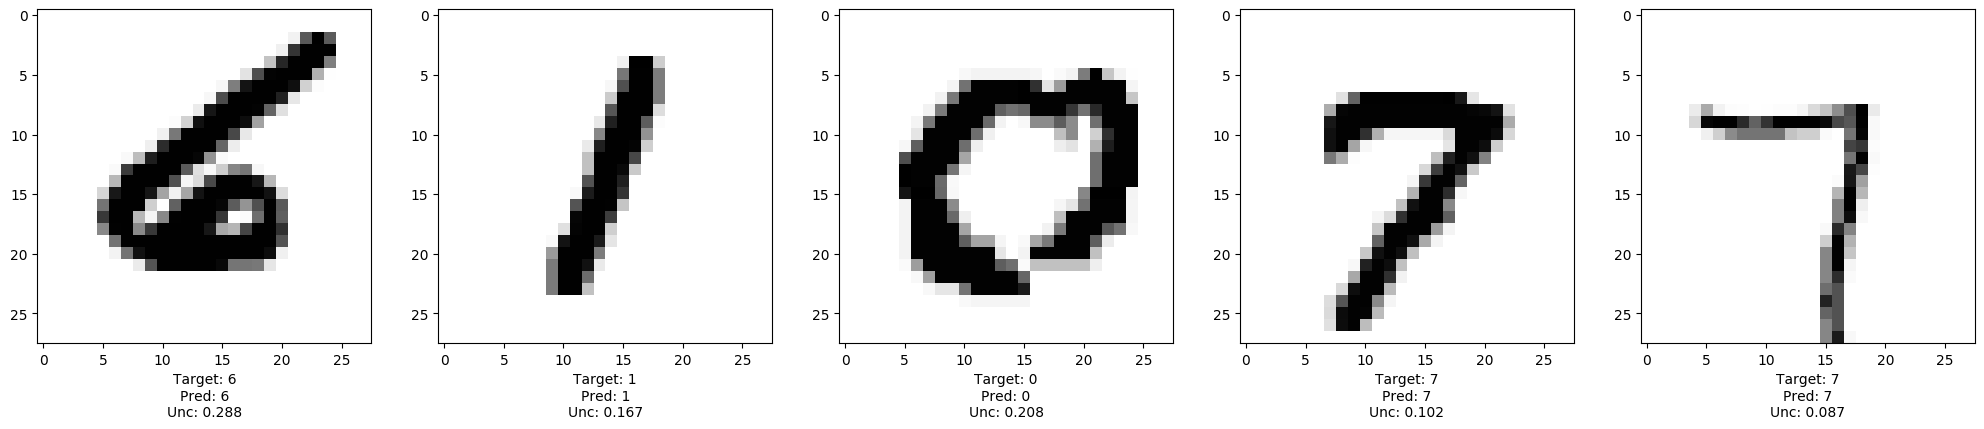

In [59]:
num_plots = 5
fig, axes = plt.subplots(1,num_plots, figsize=[5*num_plots, 5], dpi=100)
for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
    viz_dataset_sample( axes[j], dataset, idx, unc_model=unc_model )

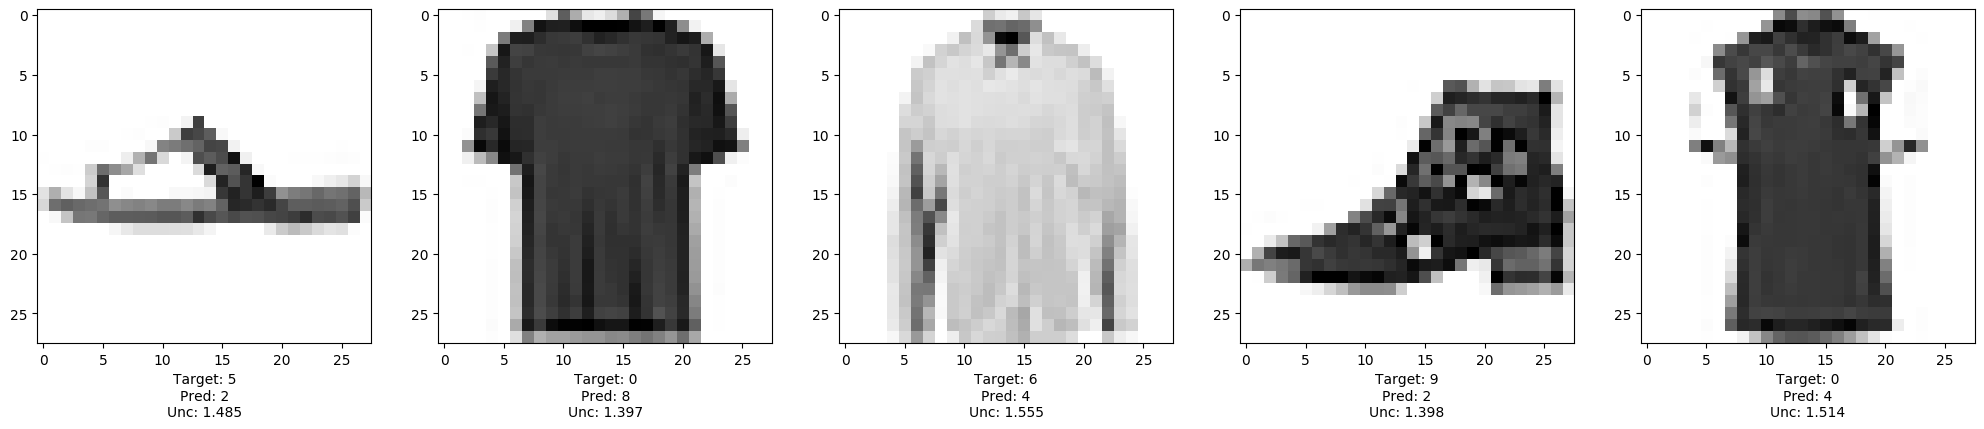

In [65]:
num_plots = 5
fig, axes = plt.subplots(1,num_plots, figsize=[5*num_plots, 5], dpi=100)
for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
    viz_dataset_sample( axes[j], val_ood_dataset, idx, unc_model=unc_model )

In [61]:
from torch.utils.data import DataLoader
from tqdm import tqdm
val_subset = Subset(val_dataset, np.random.choice(len(val_dataset), 5000))
ood_subset = Subset(val_ood_dataset, np.random.choice(len(val_ood_dataset), 5000))
kmnist_subset = Subset(kmnist_dataset, np.random.choice(len(kmnist_dataset), 5000))

val_base = torch.cat( [ unc_model(batch[0].to(unc_model.device), T=0)[1] for batch in tqdm(DataLoader(val_subset, batch_size=25, shuffle=False)) ] )
ood_base = torch.cat( [ unc_model(batch[0].to(unc_model.device), T=0)[1] for batch in tqdm(DataLoader(ood_subset, batch_size=25, shuffle=False)) ] )
kmnist_base = torch.cat( [ unc_model(batch[0].to(unc_model.device), T=0)[1] for batch in tqdm(DataLoader(kmnist_subset, batch_size=25, shuffle=False)) ] )

val_uncs = torch.cat( [ unc_model(batch[0].to(unc_model.device), T=5)[1] for batch in tqdm(DataLoader(val_subset, batch_size=25, shuffle=False)) ] )
ood_uncs = torch.cat( [ unc_model(batch[0].to(unc_model.device), T=5)[1] for batch in tqdm(DataLoader(ood_subset, batch_size=25, shuffle=False)) ] )
kmnist_uncs = torch.cat( [ unc_model(batch[0].to(unc_model.device), T=5)[1] for batch in tqdm(DataLoader(kmnist_subset, batch_size=25, shuffle=False)) ] )

val_uncs_full = torch.cat( [ unc_model(batch[0].to(unc_model.device), T=None)[1] for batch in tqdm(DataLoader(val_subset, batch_size=25, shuffle=False)) ] )
ood_uncs_full = torch.cat( [ unc_model(batch[0].to(unc_model.device), T=None)[1] for batch in tqdm(DataLoader(ood_subset, batch_size=25, shuffle=False)) ] )
kmnist_uncs_full = torch.cat( [ unc_model(batch[0].to(unc_model.device), T=None)[1] for batch in tqdm(DataLoader(kmnist_subset, batch_size=25, shuffle=False)) ] )

 52%|█████▏    | 103/200 [00:01<00:01, 58.30it/s]

100%|██████████| 200/200 [00:32<00:00,  6.10it/s]


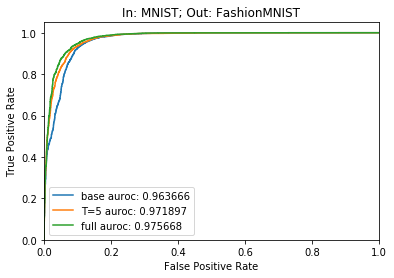

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score

groups = [
    ('base', val_base, ood_base),
    ('T=5', val_uncs, ood_uncs),
    ('full', val_uncs_full, ood_uncs_full)
]

for label, in_uncs, out_uncs in groups:
    fpr, tpr, thresh = roc_curve(np.concatenate([np.zeros(5000), np.ones(5000)]), torch.cat([in_uncs, out_uncs]).detach().cpu())
    auroc = roc_auc_score(np.concatenate([np.zeros(5000), np.ones(5000)]), torch.cat([in_uncs, out_uncs]).detach().cpu())

    plt.plot(fpr, tpr, label=(label + " auroc: %03f" % auroc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("In: MNIST; Out: FashionMNIST")
plt.show()

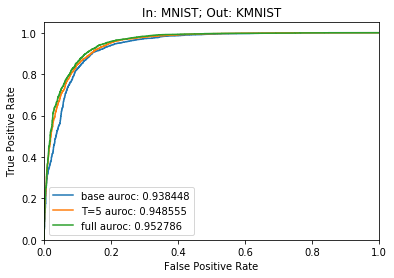

In [63]:
groups = [
    ('base', val_base, kmnist_base),
    ('T=5', val_uncs, kmnist_uncs),
    ('full', val_uncs_full, kmnist_uncs_full)
]

for label, in_uncs, out_uncs in groups:
    fpr, tpr, thresh = roc_curve(np.concatenate([np.zeros(5000), np.ones(5000)]), torch.cat([in_uncs, out_uncs]).detach().cpu())
    auroc = roc_auc_score(np.concatenate([np.zeros(5000), np.ones(5000)]), torch.cat([in_uncs, out_uncs]).detach().cpu())

    plt.plot(fpr, tpr, label=(label + " auroc: %03f" % auroc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("In: MNIST; Out: KMNIST")
plt.show()

Text(0.5, 1.0, 'SCOD')

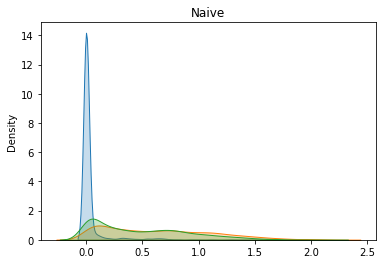

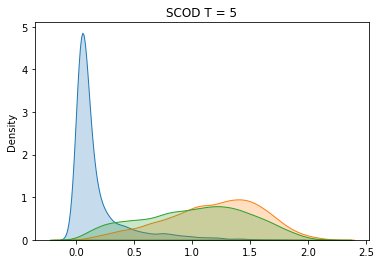

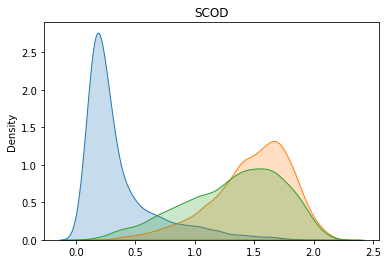

In [64]:
import seaborn as sns
plt.figure()
sns.kdeplot(val_base.detach().cpu(), fill=True)
sns.kdeplot(ood_base.detach().cpu(), fill=True)
sns.kdeplot(kmnist_base.detach().cpu(), fill=True)
plt.title("Naive")

plt.figure()
sns.kdeplot(val_uncs.detach().cpu(), fill=True)
sns.kdeplot(ood_uncs.detach().cpu(), fill=True)
sns.kdeplot(kmnist_uncs.detach().cpu(), fill=True)
plt.title("SCOD T = 5")

plt.figure()
sns.kdeplot(val_uncs_full.detach().cpu(), fill=True)
sns.kdeplot(ood_uncs_full.detach().cpu(), fill=True)
sns.kdeplot(kmnist_uncs_full.detach().cpu(), fill=True)
plt.title("SCOD")